In [ ]:
!pip3 install pyro-ppl 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install extinction

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !gdown https://drive.google.com/uc?id=1Yr5XqzWiCrHPW-u8B0wSXXxpx8jWIaCW

In [ ]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import corner
import time

import pyro

import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS, Predictive
from pyro.optim import Adam

from scipy.interpolate import interp1d
import h5py
import extinction

from astropy.cosmology import FlatLambdaCDM

from spline_hsiao_fns import *

##Get constants from files

In [ ]:
W0 = np.loadtxt("W0_T21.txt")
W1 = np.loadtxt("W1_T21.txt")
time_knots = np.loadtxt("tau_knots_T21.txt")
wavelength_knots = np.loadtxt("l_knots_T21.txt")
L_sigma_epsilon = np.loadtxt("L_Sigma_epsilon_T21.txt")
M0, sigma0, rv, tauA = np.loadtxt("M0_sigma0_RV_tauA_T21.txt")

In [ ]:
g_wavelengths, _, g_norm_throughput = np.loadtxt("g_PS1.txt", skiprows = 2, unpack = True)
r_wavelengths, _, r_norm_throughput = np.loadtxt("r_PS1.txt", skiprows = 2, unpack = True)
i_wavelengths, _, i_norm_throughput = np.loadtxt("i_PS1.txt", skiprows = 2, unpack = True)
z_wavelengths, _, z_norm_throughput = np.loadtxt("z_PS1.txt", skiprows = 2, unpack = True)

In [ ]:
cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)
z = pyro.sample("z", dist.Uniform(0.015, 0.08)).numpy()
true_mu_s = cosmo.distmod(z).value

EBV_MW = 0.

ZPT = 27.5
# M0 = -19.5
gamma = np.log(10) / 2.5

Av_obs = EBV_MW * 3.1

In [ ]:
cosmo.distmod(z).value

36.31860668668426

In [ ]:
torch.as_tensor(cosmo.distmod(z))

tensor(36.3186, dtype=torch.float64)

In [ ]:
dMs = 0.
# true_theta = pyro.sample("theta", dist.Uniform(-1.49,2.77)).numpy() #for W22
true_theta = pyro.sample("theta", dist.Uniform(-1.33,2.78)).numpy() # for T21

true_Av = pyro.sample("Av", dist.Exponential(1 / tauA)).numpy()
# Rv = 2.659


eps_cov = torch.as_tensor(np.matmul(L_sigma_epsilon, L_sigma_epsilon.T), dtype = torch.float)
# epsilon_interior = pyro.sample("eps_int", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = eps_cov))

true_nu = pyro.sample("nu", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = torch.eye(len(eps_cov))))
# true_nu = torch.zeros(54)
true_epsilon_interior = np.matmul(L_sigma_epsilon, true_nu.numpy().T)

tmax = pyro.sample("tmax", dist.Uniform(57100,57800)).numpy()
tfirst = pyro.sample("tfirst", dist.Uniform(float(tmax) - 10, float(tmax) - 5)).numpy()
times_MJD = np.array([tfirst + 6*i for i in range(6)])
times = (times_MJD - tmax) / (1 + z)

In [ ]:
L_sigma_epsilon.shape

(24, 24)

In [ ]:
times

array([-6.2110731 , -0.46049547,  5.29008215, 11.04065978, 16.79123741,
       22.54181503])

In [ ]:
hsiao_phase, hsiao_wave, hsiao_flux = read_model_grid()

Things we can pre-calculate
---



In [ ]:
def get_lambda_int_for_band(band_wavelengths, z = z):
  source_wavelengths = band_wavelengths / (1 + z)
  return np.linspace(min(source_wavelengths), max(source_wavelengths), 75)

In [ ]:
# times_to_interpolate = np.linspace(-10, 40)
times_to_interpolate = times
wavelengths_to_interpolate = get_lambda_int_for_band(z_wavelengths)

In [ ]:
Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))
Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))

In [ ]:
xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T
xis_matrix.shape

(75, 6)

In [ ]:
## interpolate Hsiao coefficient at desired time and wavelength points
S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
for i, wavelength in enumerate(wavelengths_to_interpolate):
  for j, time_point in enumerate(times_to_interpolate):
    S0[i][j] = interpolate_hsiao(time_point, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)

In [ ]:
min(wavelengths_to_interpolate * (1 + z)), max(wavelengths_to_interpolate * (1 + z))

(7940.157995219609, 9440.39335807811)

In [ ]:
min(z_wavelengths), max(z_wavelengths)

(7940.157995219609, 9440.39335807811)

In [ ]:
throughput_interpolator = interp1d(z_wavelengths, z_norm_throughput)
## I was getting a floating point problem so I fixed it by removing the last value of wavelengths_to_interpolate (1 + z) and replacing it with the max value
## z_wavelengths, which it should be anyways.
b = throughput_interpolator([z_wavelengths[0]] + list(wavelengths_to_interpolate[1:-1] * (1 + z)) + [z_wavelengths[-1]])


xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z), Av_obs, 3.1)
dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
h = (1 + z) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma * xis_obs)
h.shape

(75,)

## Simulating a curve

In [ ]:
def get_flux_from_params(epsilon_interior, theta, mu_s, dMs, Av, W0 = W0, W1 = W1, xis_matrix = xis_matrix, S0 = S0, h = h, Jl = Jl, Jt = Jt):

  epsilon = np.zeros_like(W0)   ## populate epsilon matrix
  epsilon[1:-1] = epsilon_interior.numpy().reshape((4,6), order = 'F') # should be (9,6) for W22

  W = W0 + theta.numpy()*W1 + epsilon

  JlWJt = np.matmul(Jl, np.matmul(W, Jt.T))

  Stilde = S0 * np.exp(-gamma * (JlWJt + Av.numpy() * xis_matrix))

  f = 10**(0.4 * (ZPT - mu_s.numpy() - M0 - dMs.numpy())) * np.matmul(h,Stilde)

  return f

In [ ]:
flux = get_flux_from_params(torch.as_tensor(true_epsilon_interior), torch.as_tensor(true_theta), torch.as_tensor(true_mu_s), torch.as_tensor(dMs), torch.as_tensor(true_Av))

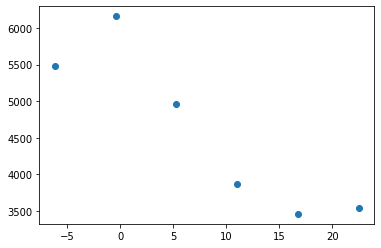

In [ ]:
plt.plot(times, flux, 'o')

Simulate for all bands at once

In [ ]:
times_to_interpolate = times
Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))

wavelengths_dict = {'g':g_wavelengths, 'r':r_wavelengths, 'i':i_wavelengths, 'z':z_wavelengths}
norm_throughput_dict = {'g':g_norm_throughput, 'r':r_norm_throughput, 'i':i_norm_throughput, 'z':z_norm_throughput}

bands = ['g', 'r', 'i', 'z']
all_band_fluxes = []

band_Jl = {}
band_xis_matrix = {}
band_S0 = {}
band_h = {}

for band in bands:
  band_wavelengths = wavelengths_dict[band]
  band_norm_throughput = norm_throughput_dict[band]

  wavelengths_to_interpolate = get_lambda_int_for_band(band_wavelengths)
  
  Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))
  band_Jl[band] = Jl
  xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
  xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T
  band_xis_matrix[band] = xis_matrix

  S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
  for i, wavelength in enumerate(wavelengths_to_interpolate):
    for j, time_point in enumerate(times_to_interpolate):
      S0[i][j] = interpolate_hsiao(time_point, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)

  band_S0[band] = S0

  throughput_interpolator = interp1d(band_wavelengths, band_norm_throughput)
  b = throughput_interpolator([band_wavelengths[0]] + list(wavelengths_to_interpolate[1:-1] * (1 + z)) + [band_wavelengths[-1]])

  xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z), Av_obs, 3.1)
  dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
  h = (1 + z) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma * xis_obs)

  band_h[band] = h

  band_flux = get_flux_from_params(torch.as_tensor(true_epsilon_interior), torch.as_tensor(true_theta), 
                              torch.as_tensor(true_mu_s), torch.as_tensor(dMs), torch.as_tensor(true_Av),
                              xis_matrix = xis_matrix, S0 = S0, h = h, Jt = Jt, Jl = Jl)
  
  all_band_fluxes.append(band_flux)

all_band_fluxes = np.array(all_band_fluxes)

In [ ]:
def get_flux_from_params2(epsilon_interior, theta, mu_s, dMs, Av, W0 = W0, W1 = W1, xis_matrix = xis_matrix, S0 = S0, h = h, Jl = Jl, Jt = Jt):

  epsilon = np.zeros_like(W0)   ## populate epsilon matrix
  epsilon[1:-1] = epsilon_interior.numpy().reshape((4,6), order = 'F') # should be (9,6) for W22

  W = W0 + theta.numpy()*W1 + epsilon

  JlWJt = np.matmul(Jl, np.matmul(W, Jt.T))

  # print(type(JlWJt))
  # print(type(Av.numpy()))
  # print(type(xis_matrix))
  # print(type(gamma))
  # print(type(S0))

  Stilde = S0 * np.exp(-gamma * (JlWJt.numpy() + Av.numpy() * xis_matrix))

  f = 10**(0.4 * (ZPT - mu_s.numpy() - M0 - dMs.numpy())) * np.matmul(h,Stilde)

  return f

In [ ]:
def get_band_specific_stuff(times, z, true_epsilon_interior, true_theta, true_mu_s, true_Av, dMs = 0, rv = rv):
  times_to_interpolate = times
  Jt = torch.as_tensor(spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots)))

  wavelengths_dict = {'g':g_wavelengths, 'r':r_wavelengths, 'i':i_wavelengths, 'z':z_wavelengths}
  norm_throughput_dict = {'g':g_norm_throughput, 'r':r_norm_throughput, 'i':i_norm_throughput, 'z':z_norm_throughput}

  bands = ['g', 'r', 'i', 'z']
  all_band_fluxes = []

  band_Jl = {}
  band_xis_matrix = {}
  band_S0 = {}
  band_h = {}

  for band in bands:
    band_wavelengths = wavelengths_dict[band]
    band_norm_throughput = norm_throughput_dict[band]

    wavelengths_to_interpolate = get_lambda_int_for_band(band_wavelengths, z)
    
    Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))
    band_Jl[band] = torch.as_tensor(Jl)
    xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
    xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T
    band_xis_matrix[band] = torch.as_tensor(xis_matrix)

    S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
    for i, wavelength in enumerate(wavelengths_to_interpolate):
      for j, time_point in enumerate(times_to_interpolate):
        S0[i][j] = interpolate_hsiao(time_point, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)

    band_S0[band] = torch.as_tensor(S0)

    throughput_interpolator = interp1d(band_wavelengths, band_norm_throughput)
    b = throughput_interpolator([band_wavelengths[0]] + list(wavelengths_to_interpolate[1:-1] * (1 + z)) + [band_wavelengths[-1]])

    xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z), Av_obs, 3.1)
    dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
    h = (1 + z) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma * xis_obs)

    band_h[band] = torch.as_tensor(h)

    band_flux = get_flux_from_params2(torch.as_tensor(true_epsilon_interior), torch.as_tensor(true_theta), 
                                torch.as_tensor(true_mu_s), torch.as_tensor(dMs), torch.as_tensor(true_Av),
                                xis_matrix = xis_matrix, S0 = S0, h = h, Jt = Jt, Jl = Jl)
    
    all_band_fluxes.append(band_flux)

  all_band_fluxes = np.array(all_band_fluxes)

  return Jt, band_Jl, band_xis_matrix, band_S0, band_h, torch.as_tensor(all_band_fluxes)

In [ ]:
all_band_fluxes

array([[7432.90853371, 8925.74082999, 7855.56395353, 5383.22180755,
        3151.31641169, 1840.9443318 ],
       [7645.29712037, 9178.918389  , 8288.94477208, 6405.26496807,
        4842.69340367, 4143.67759962],
       [6241.98784532, 6030.48033174, 5173.11987833, 3658.16652935,
        3091.65508561, 3454.57114173],
       [5484.00333158, 6160.57413968, 4965.35708763, 3870.87549698,
        3458.48431245, 3541.09415268]])

Now let's actually make the model
---

In [ ]:
true_theta, true_mu_s, true_Av

(array(-0.18556821, dtype=float32),
 36.31860668668426,
 array(0.5048223, dtype=float32))

In [ ]:
true_nu

tensor([-1.2009, -0.7613,  0.4411, -0.2356,  0.7694,  0.6199,  0.0329, -0.7983,
         0.2312,  0.8505, -0.5398,  0.6695,  0.9171,  1.3568,  0.3933, -0.1895,
        -0.4553, -0.3460, -1.7121,  0.5964, -0.0128, -1.4166,  0.4889, -0.6157])

In [ ]:
observed_z = pyro.sample("observed_z", dist.Normal(torch.as_tensor(z), 1.e-4))
mu_mean = torch.as_tensor(cosmo.distmod(observed_z.numpy()).value)

In [ ]:
def model_vi(obs):
  # epsilon_interior = pyro.sample("eps_int", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = eps_cov))

  nu = pyro.sample("nu", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = torch.eye(len(eps_cov))))
  # nu = torch.zeros(54)
  epsilon_interior = torch.matmul(torch.as_tensor(L_sigma_epsilon, dtype = torch.float), nu.float())
  # print(epsilon_interior)

  # theta = pyro.sample("theta", dist.Uniform(low=-1.49, high=2.77))
  theta = pyro.sample("theta", dist.Normal(0., 1.0))
  # theta = torch.as_tensor(0.03430605)

  # theta = torch.as_tensor(-0.9835187)
  mu_s = pyro.sample("mu_s", dist.Normal(mu_mean, 10.)) ## fix this later
  # mu_s = torch.as_tensor(37.248927127193724)

  # dMs = pyro.sample("Ms", dist.Normal(torch.tensor(0.), torch.tensor(sigma0)))
  dMs = torch.tensor(0.)
  Av = pyro.sample("Av", dist.Exponential(1 / tauA))
  # Av = torch.tensor(7.2387767)
  # Av = pyro.sample("Av", dist.Normal(0.27, 1.))

  epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
  epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,4)), 0, 1)

  W = torch.as_tensor(W0) + theta*torch.as_tensor(W1) + epsilon

  generated_fluxes = []

  for band in bands:
    Jl = band_Jl[band]
    S0 = band_S0[band]
    xis_matrix = band_xis_matrix[band]
    h = band_h[band]

    JlWJt = torch.matmul(torch.as_tensor(Jl), torch.matmul(W, torch.as_tensor(Jt.T)))

    Stilde = torch.as_tensor(S0) * torch.exp(-gamma * (JlWJt + Av * torch.as_tensor(xis_matrix)))

    f = 10**(0.4 * (torch.as_tensor(ZPT) - mu_s - torch.as_tensor(M0) - dMs)) * torch.matmul(torch.as_tensor(h), torch.as_tensor(Stilde))
    generated_fluxes.append(f)

  generated_fluxes = torch.stack(generated_fluxes)
  # print(generated_fluxes)

  with pyro.plate("bands"):
    with pyro.plate("observations"):
      pyro.sample("flux", dist.Normal(generated_fluxes, 0.02 * generated_fluxes), obs = obs)

In [ ]:
torch.as_tensor(all_band_fluxes)

tensor([[7432.9085, 8925.7408, 7855.5640, 5383.2218, 3151.3164, 1840.9443],
        [7645.2971, 9178.9184, 8288.9448, 6405.2650, 4842.6934, 4143.6776],
        [6241.9878, 6030.4803, 5173.1199, 3658.1665, 3091.6551, 3454.5711],
        [5484.0033, 6160.5741, 4965.3571, 3870.8755, 3458.4843, 3541.0942]],
       dtype=torch.float64)

In [ ]:
model_vi(torch.as_tensor(all_band_fluxes))

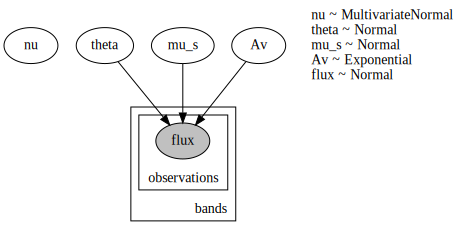

In [ ]:
pyro.render_model(model_vi, model_args = (torch.as_tensor(all_band_fluxes),), render_distributions=True, render_params = True)

In [ ]:
digraph = pyro.render_model(model_vi, model_args = (torch.as_tensor(all_band_fluxes),), render_distributions=False, render_params = True)
digraph.node("theta", label = "θ")
digraph.node("nu", label = '\N{GREEK SMALL LETTER NU}')
digraph.node("mu_s", label = '\u03BC')
digraph.node("Av", label = 'A' + '\N{LATIN SUBSCRIPT SMALL LETTER V}')
digraph.edge("nu", "flux")

In [ ]:
'\N{LATIN SUBSCRIPT SMALL LETTER V}'

'ᵥ'

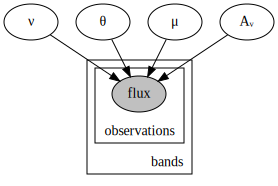

In [ ]:
digraph

In [ ]:
digraph.save()
digraph.render(filename = "Single_Supernova_PGM_072522", format='eps', view = 1, cleanup = 1)

'Single_Supernova_PGM_072522.eps'

In [ ]:
# autoguide_vi = pyro.infer.autoguide.AutoDiagonalNormal(model_vi)
autoguide_vi = pyro.infer.autoguide.AutoMultivariateNormal(model_vi, init_scale = 0.8)

In [ ]:
# class CustomMultivariateNormal(pyro.infer.autoguide.AutoMultivariateNormal):
#   def __init__(self, model, diag_eps = True, no_eps_other_params = True):
#         self.diag_eps = diag_eps
#         self.no_eps_other_params = no_eps_other_params
#         super().__init__(model)

#   def get_posterior(self, *args, **kwargs):
#     """
#     Returns a MultivariateNormal posterior distribution.
#     """
#     scale_tril = self.scale[..., None] * self.scale_tril
    
#     # # cov = torch.mm(scale_tril, scale_tril.T)
#     # # corner = cov[54:57,54:57]
#     # # chol_corner = torch.linalg.cholesky(corner)
#     # print(scale_tril.detach().numpy())
#     # plt.matshow(scale_tril.detach().numpy())
#     # plt.colorbar(norm=colors.LogNorm())

#     if self.diag_eps:
#       for i in range(54):
#         for j in range(i):
#           scale_tril[i][j] = 0
#           scale_tril[j][i] = 0
#     if self.no_eps_other_params:
#       for i in range(54, 57):
#         for j in range(54):
#           scale_tril[i][j] = 0
#           scale_tril[j][i] = 0
#     # plt.matshow(scale_tril.detach().numpy())
#     # plt.matshow(torch.mm(scale_tril, scale_tril.T).detach().numpy())
#     return dist.MultivariateNormal(self.loc, scale_tril = scale_tril)

In [ ]:
pyro.get_param_store().clear()
adam = pyro.optim.Adam({"lr": 0.01, "betas": (0.90, 0.999)}, {"clip_norm": 10.0})
# adam = pyro.optim.SGD({"lr": 0.1})


svi = SVI(model_vi, autoguide_vi, adam, loss=Trace_ELBO().differentiable_loss)
# svi = SVI(model_vi, custom_guide, adam, loss=Trace_ELBO().differentiable_loss)

for i in range(10):
  svi.step(torch.as_tensor(all_band_fluxes))

In [ ]:
# latent_dim = 57
# pyro.param("auto_scale_tril", torch.tril(torch.rand(latent_dim, latent_dim)),
#                    constraint=constraints.lower_cholesky)

## Train the model

In [ ]:
def train(model, guide, lr=0.01, n_steps=5000, verbose = True):
    pyro.get_param_store().clear()
    adam_params = {"lr": lr, "betas": (0.95, 0.999)}
    # adam = pyro.optim.Adam({"lr": 0.05}, {"clip_norm": 10.0})
    adam = pyro.optim.ClippedAdam(adam_params)
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    losses = []
    losses_every_500 = []

    for step in range(n_steps):
        loss = svi.step(torch.as_tensor(all_band_fluxes))
        losses.append(loss)
        if verbose and step % 500 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))
            losses_every_500.append(loss)
            ## if it hasn't decreased in 3 steps, end fitting
            # if step > 2000:
            #  if losses_every_500[-1] >= losses_every_500[-2] and losses_every_500[-2] >= losses_every_500[-3]:
            #   break
    return losses

In [ ]:
start_time = time.time()
losses = train(model_vi, autoguide_vi, lr = 0.005, n_steps = 20000)
end_time = time.time()
print("Time:", end_time - start_time, "seconds")

[iter 0]  loss: 30299.6019
[iter 500]  loss: 12770.7698
[iter 1000]  loss: 11429.1278
[iter 1500]  loss: 13155.1258
[iter 2000]  loss: 5246.4475
[iter 2500]  loss: 1537.7088
[iter 3000]  loss: 838.8971
[iter 3500]  loss: 509.9497
[iter 4000]  loss: 404.0866
[iter 4500]  loss: 342.5843
[iter 5000]  loss: 303.5407
[iter 5500]  loss: 269.4238
[iter 6000]  loss: 246.7244
[iter 6500]  loss: 233.8754
[iter 7000]  loss: 223.4429
[iter 7500]  loss: 219.9088
[iter 8000]  loss: 223.2907
[iter 8500]  loss: 218.9245
[iter 9000]  loss: 221.4487
[iter 9500]  loss: 215.1292
[iter 10000]  loss: 215.5429
[iter 10500]  loss: 213.9698
[iter 11000]  loss: 222.5733
[iter 11500]  loss: 213.7625
[iter 12000]  loss: 216.3151
[iter 12500]  loss: 217.8345
[iter 13000]  loss: 217.1721
[iter 13500]  loss: 215.3375
[iter 14000]  loss: 217.8974
[iter 14500]  loss: 216.5614
[iter 15000]  loss: 219.0799
[iter 15500]  loss: 216.2515
[iter 16000]  loss: 214.8300
[iter 16500]  loss: 213.2480
[iter 17000]  loss: 213.5172

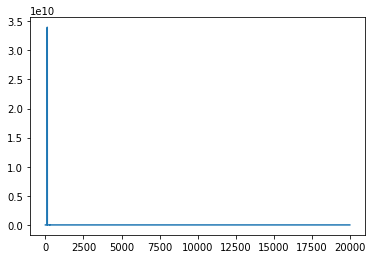

In [ ]:
plt.plot(losses)

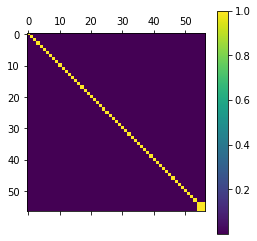

In [ ]:
cov = np.ones((57, 57))
for i in range(54):
  for j in range(i):
    cov[i][j] = 0.0001
    cov[j][i] = 0.0001
for i in range(54, 57):
  for j in range(54):
    cov[i][j] = 0.0001
    cov[j][i] = 0.0001
plt.matshow(cov)
plt.colorbar()

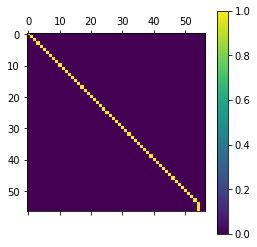

In [ ]:
plt.matshow(np.linalg.cholesky(cov))
plt.colorbar()

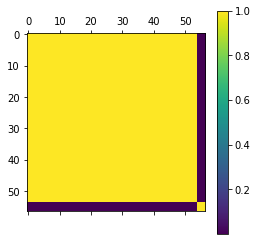

In [ ]:
cov = np.ones((57, 57))
# for i in range(54):
#   for j in range(i):
#     cov[i][j] = 0.0001
#     cov[j][i] = 0.0001
for i in range(54, 57):
  for j in range(54):
    cov[i][j] = 0.0001
    cov[j][i] = 0.0001
plt.matshow(cov)
plt.colorbar()

In [ ]:
autoguide_vi.median()['theta'], true_theta

(tensor(1.1596, dtype=torch.float64), array(1.2835461, dtype=float32))

In [ ]:
autoguide_vi.median()['Av'], true_Av

(tensor(0.5397, dtype=torch.float64), array(0.54380345, dtype=float32))

In [ ]:
autoguide_vi.median()['mu_s'], true_mu_s

(tensor(34.0733, dtype=torch.float64), 34.04453653904879)

In [ ]:
autoguide_vi.median()['nu'], true_nu

(tensor([ 0.8440, -1.8271, -0.1998, -0.6843,  0.2350,  0.8333,  0.6122, -0.2014,
         -0.1873,  0.3790,  0.1651, -1.1976, -0.0754, -0.6992, -0.4758, -1.1591,
         -0.1989,  0.0699,  0.1123,  0.0595,  0.0848, -0.0143, -0.0876, -0.0169],
        dtype=torch.float64),
 tensor([ 0.6823, -1.8338, -0.0643, -0.7823,  0.0768,  1.1700,  0.9453, -0.1595,
         -0.4407,  0.3716,  0.4319, -1.3344, -0.5345, -0.7906, -0.5179, -1.3179,
         -1.3576, -0.5201,  0.1831, -0.1468,  0.2393,  0.3294, -1.2244,  0.9840]))

In [ ]:
custom_guide = CustomMultivariateNormal(model_vi)
start_time = time.time()
losses = train(model_vi, custom_guide, n_steps = 10000)
end_time = time.time()
print("Time:", end_time - start_time, "seconds")

[iter 0]  loss: 24147.4069


KeyboardInterrupt: ignored

In [ ]:
custom_guide_full_eps = CustomMultivariateNormal(model_vi, diag_eps = False)
start_time = time.time()
losses = train(model_vi, custom_guide_full_eps, n_steps = 10000)
end_time = time.time()
print("Time:", end_time - start_time, "seconds")

In [ ]:
autoguide_laplace = pyro.infer.autoguide.AutoLaplaceApproximation(model_vi)
start_time = time.time()
losses = train(model_vi, autoguide_laplace, n_steps = 10000)
end_time = time.time()
print("Time:", end_time - start_time, "seconds")

[iter 0]  loss: 30269.1978
[iter 500]  loss: 3514.8898
[iter 1000]  loss: 336.0966
[iter 1500]  loss: 235.1709
[iter 2000]  loss: 213.9599
[iter 2500]  loss: 211.3211
[iter 3000]  loss: 211.1181
[iter 3500]  loss: 211.0730
[iter 4000]  loss: 211.0474
[iter 4500]  loss: 211.0899
[iter 5000]  loss: 211.0495
[iter 5500]  loss: 211.0473
[iter 6000]  loss: 211.0901
[iter 6500]  loss: 211.0498
[iter 7000]  loss: 211.0475
[iter 7500]  loss: 211.0907
[iter 8000]  loss: 211.0500
[iter 8500]  loss: 211.0476
[iter 9000]  loss: 211.0911
[iter 9500]  loss: 211.0502
Time: 67.84048700332642 seconds


In [ ]:
new_laplace_approx_guide = autoguide_laplace.laplace_approximation(torch.as_tensor(all_band_fluxes))
losses = train(model_vi, new_laplace_approx_guide, n_steps = 10000)

[iter 0]  loss: 218.6054
[iter 500]  loss: 215.4077
[iter 1000]  loss: 216.4882
[iter 1500]  loss: 223.9677
[iter 2000]  loss: 213.9566
[iter 2500]  loss: 216.0442
[iter 3000]  loss: 209.8608
[iter 3500]  loss: 213.5996
[iter 4000]  loss: 212.5232
[iter 4500]  loss: 213.7317
[iter 5000]  loss: 213.7671
[iter 5500]  loss: 212.2687
[iter 6000]  loss: 213.9105
[iter 6500]  loss: 215.3632
[iter 7000]  loss: 215.1778
[iter 7500]  loss: 215.4680
[iter 8000]  loss: 215.7884
[iter 8500]  loss: 216.0361
[iter 9000]  loss: 214.6783
[iter 9500]  loss: 214.4331


In [ ]:
def calculate_all_fluxes_from_params(nu, theta, mu_s, dMs, Av):
  times_to_interpolate = np.linspace(-10, 30)
  Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))

  epsilon_interior = np.matmul(L_sigma_epsilon, nu.numpy().T)

  epsilon = np.zeros_like(W0)   ## populate epsilon matrix
  epsilon[1:-1] = epsilon_interior.reshape((4,6), order = 'F')

  W = W0 + theta.numpy()*W1 + epsilon

  generated_fluxes_from_params = []

  for band in bands:
    band_wavelengths = wavelengths_dict[band]
    band_norm_throughput = norm_throughput_dict[band]

    Jl = band_Jl[band]
    # xis_matrix = band_xis_matrix[band]
    # h = band_h[band]

    wavelengths_to_interpolate = get_lambda_int_for_band(band_wavelengths)
    
    # Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))
    xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
    xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T

    S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
    for i, wavelength in enumerate(wavelengths_to_interpolate):
      for j, time in enumerate(times_to_interpolate):
        S0[i][j] = interpolate_hsiao(time, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)

    throughput_interpolator = interp1d(band_wavelengths, band_norm_throughput)
    b = throughput_interpolator([band_wavelengths[0]] + list(wavelengths_to_interpolate[1:-1] * (1 + z)) + [band_wavelengths[-1]])

    xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z), Av_obs, 3.1)
    dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
    h = (1 + z) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma * xis_obs)

    band_flux = get_flux_from_params(torch.as_tensor(epsilon_interior), torch.as_tensor(theta), 
                                torch.as_tensor(mu_s), torch.as_tensor(dMs), torch.as_tensor(Av),
                                xis_matrix = xis_matrix, S0 = S0, h = h, Jt = Jt, Jl = Jl)
    
    generated_fluxes_from_params.append(band_flux)
  
  return np.array(generated_fluxes_from_params)

In [ ]:
median_fluxes = calculate_all_fluxes_from_params(autoguide_vi.median()['nu'], autoguide_vi.median()['theta'], autoguide_vi.median()['mu_s'], torch.as_tensor(0.), autoguide_vi.median()['Av'])

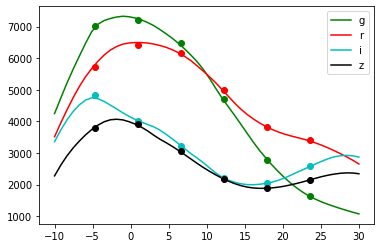

In [ ]:
colors  = ['g', 'r', 'c', 'k']
for i, band_flux in enumerate(median_fluxes):
  plt.plot(np.linspace(-10, 30), band_flux, label = bands[i], color = colors[i])
for i, band_flux in enumerate(all_band_fluxes):
  plt.plot(times, band_flux, 'o',color = colors[i])
plt.legend()

In [ ]:
lower_quartile = autoguide_vi.quantiles([0.5 - 0.341])
upper_quartile = autoguide_vi.quantiles([0.5 + 0.341])
median = autoguide_vi.quantiles([0.5])

In [ ]:
upper_bound = calculate_all_fluxes_from_params(upper_quartile['nu'], upper_quartile['theta'], upper_quartile['mu_s'], torch.as_tensor(0.), upper_quartile['Av'])
lower_bound = calculate_all_fluxes_from_params(lower_quartile['nu'], lower_quartile['theta'], lower_quartile['mu_s'], torch.as_tensor(0.), lower_quartile['Av'])
median_flux = calculate_all_fluxes_from_params(median['nu'], median['theta'], median['mu_s'], torch.as_tensor(0.), median['Av'])

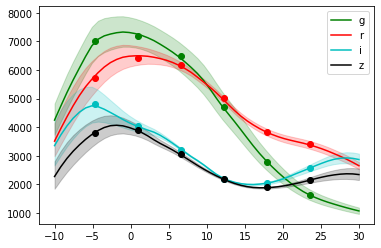

In [ ]:
colors  = ['g', 'r', 'c', 'k']
for i, band_flux in enumerate(median_flux):
  plt.plot(np.linspace(-10, 30), band_flux, label = bands[i], color = colors[i])
  plt.fill_between(np.linspace(-10, 30), upper_bound[i], lower_bound[i], color = colors[i], alpha = 0.2)
for i, band_flux in enumerate(all_band_fluxes):
  plt.plot(times, band_flux, 'o',color = colors[i])
plt.legend()

## Compare with MCMC

In [ ]:
def model_mcmc(obs = torch.as_tensor(all_band_fluxes)):
  # epsilon_interior = pyro.sample("eps_int", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = eps_cov))

  nu = pyro.sample("nu", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = torch.eye(len(eps_cov))))
  # nu = torch.zeros(54)
  nu = torch.as_tensor(torch.squeeze(nu), dtype = torch.double)
  # print(nu.type())
  epsilon_interior = torch.matmul(torch.as_tensor(L_sigma_epsilon, dtype = torch.double), nu)
  # print(epsilon_interior)

  # theta = pyro.sample("theta", dist.Uniform(low=-1.49, high=2.77))
  theta = pyro.sample("theta", dist.Normal(0., 1.0))
  # theta = torch.as_tensor(0.03430605)

  # theta = torch.as_tensor(-0.9835187)
  mu_s = pyro.sample("mu_s", dist.Normal(mu_mean, 10.)) ## fix this later
  # mu_s = torch.as_tensor(37.248927127193724)

  # dMs = pyro.sample("Ms", dist.Normal(torch.tensor(0.), torch.tensor(sigma0)))
  dMs = torch.tensor(0.)
  Av = pyro.sample("Av", dist.Exponential(1 / tauA))
  # Av = torch.tensor(7.2387767)
  # Av = pyro.sample("Av", dist.Normal(0.27, 1.))

  epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
  epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,4)), 0, 1)

  W = torch.as_tensor(W0) + theta*torch.as_tensor(W1) + epsilon

  generated_fluxes = []

  for band in bands:
    Jl = band_Jl[band]
    S0 = band_S0[band]
    xis_matrix = band_xis_matrix[band]
    h = band_h[band]

    JlWJt = torch.matmul(torch.as_tensor(Jl), torch.matmul(W, torch.as_tensor(Jt.T)))

    Stilde = torch.as_tensor(S0) * torch.exp(-gamma * (JlWJt + Av * torch.as_tensor(xis_matrix)))

    f = 10**(0.4 * (torch.as_tensor(ZPT) - mu_s - torch.as_tensor(M0) - dMs)) * torch.matmul(torch.as_tensor(h), torch.as_tensor(Stilde))
    generated_fluxes.append(f)

  generated_fluxes = torch.stack(generated_fluxes)
  # print(generated_fluxes)

  with pyro.plate("bands"):
    with pyro.plate("observations"):
      pyro.sample("flux", dist.Normal(generated_fluxes, 0.02 * generated_fluxes), obs = obs)

In [ ]:
num_chains = 1

initial_params = {'mu_s':torch.tensor([pyro.sample("mu_s", dist.Normal(mu_mean, 0.5)) for i in range(num_chains)]),
                  'theta': torch.tensor([pyro.sample("theta", dist.Normal(0., 1.0)) for i in range(num_chains)]),
                  'Av': torch.tensor([pyro.sample("Av", dist.Exponential(1 / tauA)) for i in range(num_chains)]),
                  'nu': torch.stack([pyro.sample("nu", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = torch.eye(len(eps_cov)))) for i in range(num_chains)])}

In [ ]:
nuts_kernel = pyro.infer.NUTS(model_mcmc, adapt_step_size=True)

mcmc = pyro.infer.MCMC(nuts_kernel, initial_params = initial_params, num_samples=600, warmup_steps=250, num_chains = num_chains, disable_progbar = True)

start_time = time.time()
mcmc.run(torch.as_tensor(all_band_fluxes))
end_time = time.time()
print("Total:", end_time - start_time, "seconds")

Total: 628.512350320816 seconds


In [ ]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     Av[0]      0.54      0.07      0.54      0.42      0.65    151.32      1.00
   mu_s[0]     34.07      0.06     34.07     33.98     34.17    127.12      1.00
   nu[0,0]      0.87      0.47      0.87      0.02      1.50    145.91      1.00
   nu[0,1]     -1.79      0.25     -1.78     -2.16     -1.38    258.20      1.00
   nu[0,2]     -0.19      0.29     -0.19     -0.64      0.32    192.48      1.00
   nu[0,3]     -0.67      0.31     -0.68     -1.19     -0.19    218.28      1.00
   nu[0,4]      0.18      0.76      0.15     -1.03      1.52    187.45      1.00
   nu[0,5]      0.87      0.60      0.86     -0.02      1.93    258.64      1.01
   nu[0,6]      0.68      0.70      0.67     -0.36      1.93    141.44      1.00
   nu[0,7]     -0.14      0.60     -0.13     -1.20      0.72    197.02      1.00
   nu[0,8]     -0.19      0.54     -0.18     -1.03      0.78    247.56      1.00
   nu[0,9]      0.44      0

In [ ]:
mcmc.get_samples(num_samples = 100)['theta'].median(), mcmc.get_samples(num_samples = 100)['Av'].median(), mcmc.get_samples(num_samples = 100)['mu_s'].median()

(tensor(1.1690, dtype=torch.float64),
 tensor(0.5466, dtype=torch.float64),
 tensor(34.0621, dtype=torch.float64))

In [ ]:
median['theta'], median['Av'], median['mu_s']

NameError: ignored

In [ ]:
true_theta, true_Av, true_mu_s

(array(-1.4260887, dtype=float32),
 array(0.3082045, dtype=float32),
 37.064628077409765)

In [ ]:
mcmc_median_vals = {}
for param in ['theta', 'Av', 'mu_s', 'nu']:
  if param == 'nu':
    mcmc_median_vals[param] = mcmc.get_samples(num_samples = 100)[param].median(dim = 0).values.float()
  else:
    mcmc_median_vals[param] = mcmc.get_samples(num_samples = 100)[param].median().float()

In [ ]:
mcmc_median_vals

In [ ]:
mcmc.get_samples(num_samples = 100)['Av']

In [ ]:
mcmc_posterior_samples = Predictive(model_mcmc, num_samples = 100)(None,)
# mcmc_posterior_samples

In [ ]:
posterior_samples = Predictive(model_vi, guide = autoguide_vi, num_samples = 100)(None,)
posterior_samples['Av'][:,0,0].shape

torch.Size([100])

In [ ]:
custom_guide_samples = Predictive(model_vi, guide = custom_guide, num_samples = 100)(None,)
custom_guide_samples['Av'][:,0,0].shape

In [ ]:
custom_guide_full_eps
custom_guide_full_eps_samples = Predictive(model_vi, guide = custom_guide_full_eps, num_samples = 100)(None,)
custom_guide_full_eps_samples['Av'][:,0,0].shape

In [ ]:
custom_guide_smooth_curves = []
for nu, theta, mu_s, Av in zip(custom_guide_samples['nu'][:,0,0], custom_guide_samples['theta'][:,0,0], custom_guide_samples['mu_s'][:,0,0], custom_guide_samples['Av'][:,0,0]):
  # print(nu, theta, mu_s, Av)
  custom_guide_smooth_curves.append(calculate_all_fluxes_from_params(nu, theta, mu_s, torch.as_tensor(0.), Av))

In [ ]:
posterior_smooth_curves = []
for nu, theta, mu_s, Av in zip(posterior_samples['nu'][:,0,0], posterior_samples['theta'][:,0,0], posterior_samples['mu_s'][:,0,0], posterior_samples['Av'][:,0,0]):
  # print(nu, theta, mu_s, Av)
  posterior_smooth_curves.append(calculate_all_fluxes_from_params(nu, theta, mu_s, torch.as_tensor(0.), Av))

In [ ]:
# posterior_smooth_curves = []
# for this_theta, this_mu_s, this_Av in zip(posterior_samples['theta'][:,0,0], posterior_samples['mu_s'][:,0,0], posterior_samples['Av'][:,0,0]):
#   # print(nu, theta, mu_s, Av)
#   posterior_smooth_curves.append(calculate_all_fluxes_from_params(true_nu, this_theta, this_mu_s, torch.as_tensor(0.), this_Av))

In [ ]:
posterior_smooth_curves = np.array(posterior_smooth_curves)

In [ ]:
median_posterior_fit = np.median(posterior_smooth_curves, axis = 0)
upper_posterior_fit = np.percentile(posterior_smooth_curves, 50 + 34.1, axis = 0)
lower_posterior_fit = np.percentile(posterior_smooth_curves, 50 - 34.1, axis = 0)

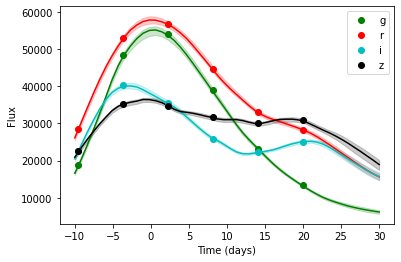

In [ ]:
f = plt.figure()
colors  = ['g', 'r', 'c', 'k']
for i, band_flux in enumerate(median_posterior_fit):
    plt.plot(np.linspace(-10, 30), band_flux, color = colors[i])
    plt.fill_between(np.linspace(-10, 30), upper_posterior_fit[i], lower_posterior_fit[i], color = colors[i], alpha = 0.2)
for i, band_flux in enumerate(all_band_fluxes):
  plt.plot(times, band_flux, 'o',color = colors[i], label = bands[i])
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("Flux")
f.savefig("SimulatedLightCurve_072722.pdf")
# plt.title("Posterior samples from VI")

In [ ]:
# mcmc_posterior_samples

In [ ]:
mcmc_smooth_curves = []

mcmc_posterior_samples = mcmc.get_samples(num_samples = 100)
# print(mcmc_posterior_samples)
for nu, theta, mu_s, Av in zip(mcmc_posterior_samples['nu'], mcmc_posterior_samples['theta'], mcmc_posterior_samples['mu_s'], mcmc_posterior_samples['Av']):
  # print(nu, theta, mu_s, Av)
  mcmc_smooth_curves.append(calculate_all_fluxes_from_params(nu, theta, mu_s, torch.as_tensor(0.), Av))

KeyboardInterrupt: ignored

In [ ]:
# mcmc_smooth_curves = []

# mcmc_posterior_samples = mcmc.get_samples(num_samples = 100)
# # print(mcmc_posterior_samples)
# for this_theta, this_mu_s, this_Av in zip(mcmc_posterior_samples['theta'], mcmc_posterior_samples['mu_s'], mcmc_posterior_samples['Av']):
#   # print(nu, theta, mu_s, Av)
#   mcmc_smooth_curves.append(calculate_all_fluxes_from_params(true_nu, this_theta, this_mu_s, torch.as_tensor(0.), this_Av))

In [ ]:
median_mcmc_fit = np.median(mcmc_smooth_curves, axis = 0)
upper_mcmc_fit = np.percentile(mcmc_smooth_curves, 50 + 34.1, axis = 0)
lower_mcmc_fit = np.percentile(mcmc_smooth_curves, 50 - 34.1, axis = 0)

In [ ]:
colors  = ['g', 'r', 'c', 'k']
for i, band_flux in enumerate(median_mcmc_fit):
    plt.plot(np.linspace(-10, 30), band_flux, color = colors[i])
    plt.fill_between(np.linspace(-10, 30), upper_mcmc_fit[i], lower_mcmc_fit[i], color = colors[i], alpha = 0.2)
for i, band_flux in enumerate(all_band_fluxes):
  plt.plot(times, band_flux, 'o',color = colors[i], label = bands[i])
plt.legend()
plt.title("Posterior samples from MCMC")

In [ ]:
num_corner_samples = 10000
mcmc_corner_samples = mcmc.get_samples(num_samples = num_corner_samples)

In [ ]:
vi_corner_samples = Predictive(model_vi, guide = autoguide_vi, num_samples = num_corner_samples)(None,)

In [ ]:
custom_vi_corner_samples = Predictive(model_vi, guide = custom_guide, num_samples = num_corner_samples)(None,)

KeyboardInterrupt: ignored

In [ ]:
custom_vi_full_eps_corner_samples = Predictive(model_vi, guide = custom_guide_full_eps, num_samples = num_corner_samples)(None,)

In [ ]:
laplace_guide = autoguide_laplace.laplace_approximation(torch.as_tensor(all_band_fluxes))

In [ ]:
laplace_corner_samples = Predictive(model_vi, guide = laplace_guide, num_samples = num_corner_samples)(None,)

KeyboardInterrupt: ignored

In [ ]:
vi_trained_laplace_samples = Predictive(model_vi, guide = new_laplace_approx_guide, num_samples = num_corner_samples)(None,)

In [ ]:
mcmc_corner_samples['Av'].shape

torch.Size([10000, 1])

In [ ]:
laplace_corner_samples['mu_s'][:,0,0].numpy()

In [ ]:
laplace_approx = [laplace_corner_samples['mu_s'][:,0,0].detach().numpy()[0], laplace_corner_samples['theta'][:,0,0].detach().numpy()[0], laplace_corner_samples['Av'][:,0,0].detach().numpy()[0]]

In [ ]:
laplace_approx

In [ ]:
autoguide_from_mcmc = pyro.infer.autoguide.AutoMultivariateNormal(model_vi, init_loc_fn = pyro.infer.autoguide.initialization.init_to_value(values=mcmc_median_vals), init_scale = 0.8)
losses = train(model_vi, autoguide_from_mcmc, lr = 0.005, n_steps = 20000)

In [ ]:
mcmc_corner_samples['mu_s'][:,0].numpy()

array([37.16406433, 37.15493694, 37.13819202, ..., 37.23243493,
       37.17469096, 37.12076178])

In [ ]:
vi_from_mcmc_corner_samples = Predictive(model_vi, guide = autoguide_from_mcmc, num_samples = num_corner_samples)(None,)

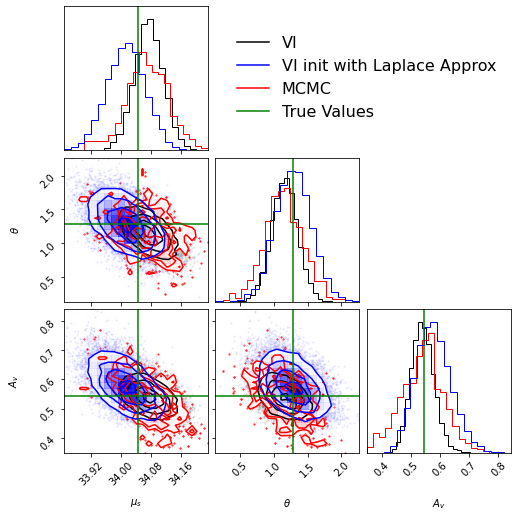

In [ ]:
figure = corner.corner(np.vstack((vi_corner_samples['mu_s'][:,0,0].numpy(),vi_corner_samples['theta'][:,0,0].numpy(), 
                                  vi_corner_samples['Av'][:,0,0].numpy())).T, 
                       labels = [r"VI $\mu_s$", r"VI $\theta$", r"VI $A_v$"])
# corner.corner(np.vstack((custom_vi_corner_samples['mu_s'][:,0,0].numpy(),custom_vi_corner_samples['theta'][:,0,0].numpy(), 
#                                  custom_vi_corner_samples['Av'][:,0,0].numpy())).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color ='b')
# corner.corner(np.vstack((custom_vi_full_eps_corner_samples['mu_s'][:,0,0].numpy(),custom_vi_full_eps_corner_samples['theta'][:,0,0].numpy(), 
#                                  custom_vi_full_eps_corner_samples['Av'][:,0,0].numpy())).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color ='c')
# corner.corner(np.vstack((laplace_corner_samples['mu_s'][:,0,0].numpy(),laplace_corner_samples['theta'][:,0,0].numpy(), 
#                                  laplace_corner_samples['Av'][:,0,0].numpy())).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color ='b')
corner.corner(np.vstack((mcmc_corner_samples['mu_s'][:,0].numpy(),mcmc_corner_samples['theta'][:,0].numpy(),mcmc_corner_samples['Av'][:,0].numpy())).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color ='r')
# corner.corner(np.vstack((vi_from_mcmc_corner_samples['mu_s'][:,0,0].numpy(),vi_from_mcmc_corner_samples['theta'][:,0,0].numpy(), 
#                                  vi_from_mcmc_corner_samples['Av'][:,0,0].numpy())).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color ='c')
 
corner.corner(np.vstack((vi_trained_laplace_samples['mu_s'][:,0,0].numpy(),vi_trained_laplace_samples['theta'][:,0,0].numpy(), 
                                 vi_trained_laplace_samples['Av'][:,0,0].numpy())).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color ='b')
# corner.corner(np.vstack((mcmc_corner_samples['mu_s'][7500:10000],mcmc_corner_samples['theta'][7500:10000],mcmc_corner_samples['Av'][7500:10000])).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color  = 'r')
# corner.corner(np.vstack((mcmc_corner_samples['mu_s'][2500:5000],mcmc_corner_samples['theta'][2500:5000],mcmc_corner_samples['Av'][2500:5000])).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color  = 'b')
corner.overplot_lines(figure, [true_mu_s, true_theta, true_Av], color = 'g')
# corner.overplot_lines(figure, laplace_approx, color = 'tab:purple')

# colors = ['k','b','c', 'r', 'g', 'tab:purple']
# labels = ['VI (Full Matrix)', 'VI (Custom Matrix)', 'VI (Custom Matrix - Full eps)', 'MCMC', 'True Values', 'Laplace Approx']
colors = ['k','b' ,'r', 'g']

labels = ['VI', 'VI init with Laplace Approx', 'MCMC', 'True Values' ]

plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=labels[i])
        for i in range(len(labels))
    ],
    fontsize=16, frameon=False,
    bbox_to_anchor=(1, 3), loc="upper right"
)

figure.savefig("Simulated_Light_Curve_Corner_Plot_072722.pdf")

## Generating 100 simulated supernovae and fitting them

In [ ]:
def model_vi_w_params(obs, mu_mean, Jt, band_Jl, band_xis_matrix, band_S0, band_h):
  # epsilon_interior = pyro.sample("eps_int", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = eps_cov))

  nu = pyro.sample("nu", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = torch.eye(len(eps_cov))))
  # nu = torch.zeros(54)
  epsilon_interior = torch.matmul(torch.as_tensor(L_sigma_epsilon, dtype = torch.float), nu.float())
  # print(epsilon_interior)

  # theta = pyro.sample("theta", dist.Uniform(low=-1.49, high=2.77))
  theta = pyro.sample("theta", dist.Normal(0., 1.0))
  # theta = torch.as_tensor(0.03430605)

  # theta = torch.as_tensor(-0.9835187)
  mu_s = pyro.sample("mu_s", dist.Normal(mu_mean, 10.)) ## fix this later
  # mu_s = torch.as_tensor(37.248927127193724)

  # dMs = pyro.sample("Ms", dist.Normal(torch.tensor(0.), torch.tensor(sigma0)))
  dMs = torch.tensor(0.)
  Av = pyro.sample("Av", dist.Exponential(1 / tauA))
  # Av = torch.tensor(7.2387767)
  # Av = pyro.sample("Av", dist.Normal(0.27, 1.))

  epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
  epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,4)), 0, 1)

  W = torch.as_tensor(W0) + theta*torch.as_tensor(W1) + epsilon

  generated_fluxes = []

  for band in bands:
    Jl = band_Jl[band]
    S0 = band_S0[band]
    xis_matrix = band_xis_matrix[band]
    h = band_h[band]

    JlWJt = torch.matmul(Jl, torch.matmul(W, torch.t(Jt)))

    Stilde = S0 * torch.exp((-gamma * (JlWJt + Av * xis_matrix)))

    f = 10**(0.4 * (torch.as_tensor(ZPT) - mu_s - torch.as_tensor(M0) - dMs)) * torch.matmul(h, Stilde)
    generated_fluxes.append(f)

  generated_fluxes = torch.stack(generated_fluxes)
  # print(generated_fluxes)

  with pyro.plate("bands"):
    with pyro.plate("observations"):
      pyro.sample("flux", dist.Normal(generated_fluxes, 0.02 * generated_fluxes), obs = obs)

In [ ]:
def train_w_params(model, guide, obs, mu_mean, Jt, band_Jl, band_xis_matrix, band_S0, band_h, lr=0.01, n_steps=5000, verbose= False):
  pyro.get_param_store().clear()
  # adam = pyro.optim.Adam({"lr": 0.05}, {"clip_norm": 10.0})
  adam = pyro.optim.ClippedAdam({"lr": lr, "betas": (0.95, 0.999)})
  svi = SVI(model, guide, adam, loss=Trace_ELBO())
  # print('hi')
  for step in range(n_steps):
      loss = svi.step(obs, mu_mean, Jt, band_Jl, band_xis_matrix, band_S0, band_h)
      if verbose and step % 500 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))
          ## if it hasn't decreased in 3 steps, end fitting
          # if step > 2000:
          #  if losses_every_500[-1] >= losses_every_500[-2] and losses_every_500[-2] >= losses_every_500[-3]:
          #   break

In [ ]:
true_distances = []
true_thetas = []
true_avs = []
true_nus = []
true_zs = []

vi_laplace_locs = []
vi_laplace_scale_trils = []

while len(true_distances) < 500:

  try:
    z = pyro.sample("z", dist.Uniform(0.015, 0.08)).numpy()
    true_mu_s = cosmo.distmod(z).value

    true_theta = pyro.sample("theta", dist.Uniform(-1.33,2.78)).numpy() # for T21

    true_Av = pyro.sample("Av", dist.Exponential(1 / tauA)).numpy()

    true_nu = pyro.sample("nu", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = torch.eye(len(eps_cov)))).numpy()

    true_epsilon_interior = np.matmul(L_sigma_epsilon, true_nu.T)

    tmax = pyro.sample("tmax", dist.Uniform(57100,57800)).numpy()
    tfirst = pyro.sample("tfirst", dist.Uniform(float(tmax) - 10, float(tmax) - 5)).numpy()
    times_MJD = np.array([tfirst + 6*i for i in range(6)])
    times = (times_MJD - tmax) / (1 + z)

    observed_z = pyro.sample("observed_z", dist.Normal(torch.as_tensor(z), 1.e-4))
    mu_mean = torch.as_tensor(cosmo.distmod(observed_z.numpy()).value)

    Jt, band_Jl, band_xis_matrix, band_S0, band_h, all_band_fluxes = get_band_specific_stuff(times, z, true_epsilon_interior, true_theta, true_mu_s, true_Av, dMs = 0)

    autoguide_laplace = pyro.infer.autoguide.AutoLaplaceApproximation(model_vi_w_params)
    losses = train_w_params(model_vi_w_params, autoguide_laplace, all_band_fluxes, mu_mean, Jt, band_Jl, band_xis_matrix, band_S0, band_h, n_steps = 5000, verbose = False)

    new_laplace_approx_guide = autoguide_laplace.laplace_approximation(torch.as_tensor(all_band_fluxes),mu_mean, Jt, band_Jl, band_xis_matrix, band_S0, band_h)
    losses = train_w_params(model_vi_w_params, new_laplace_approx_guide, all_band_fluxes, mu_mean, Jt, band_Jl, band_xis_matrix, band_S0, band_h, n_steps = 5000, verbose = False)

    true_zs.append(z)
    true_distances.append(true_mu_s)
    true_thetas.append(true_theta)
    true_avs.append(true_Av)
    true_nus.append(true_nu)
    vi_laplace_locs.append(new_laplace_approx_guide.get_posterior().loc.numpy())
    vi_laplace_scale_trils.append(new_laplace_approx_guide.get_posterior().scale_tril.numpy())


    np.savez("simulation_true_values_072822", true_zs=np.array(true_zs), true_distances=np.array(true_distances), true_thetas=np.array(true_thetas), true_avs=np.array(true_avs), true_nus=np.array(true_nus))

    np.save("simulation_locs_072822", vi_laplace_locs)
    np.save("simulation_scale_trils_072822", vi_laplace_scale_trils)
  except:
    print("didn't work")



didn't work
didn't work
didn't work
didn't work
didn't work
didn't work
didn't work
didn't work
didn't work
didn't work
didn't work
didn't work
didn't work
didn't work
didn't work
didn't work


In [ ]:
from google.colab import files
files.download("simulation_true_values_072822.npz")
files.download('simulation_locs_072822.npy')
files.download('simulation_scale_trils_072822.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Analyze these simulations

In [ ]:
simulation_true_values = np.load("simulation_true_values_072822(5).npz")
simulation_true_values.files

['true_zs', 'true_distances', 'true_thetas', 'true_avs', 'true_nus']

In [ ]:
true_mus = simulation_true_values['true_distances']
true_thetas = simulation_true_values['true_thetas']
true_avs = simulation_true_values['true_avs']
true_nus = simulation_true_values['true_nus']
true_zs = simulation_true_values['true_zs']


In [ ]:
simulation_locs = np.load("simulation_locs_072822(5).npy")
simulation_scale_trils=  np.load("simulation_scale_trils_072822(5).npy")

In [ ]:
len(simulation_locs)

500

In [ ]:
fit_mus = []
fit_thetas = []
fit_avs = []

mu_variances = []

for i in range(len(true_mus)):
  fit_mus.append(simulation_locs[i][-2])
  fit_thetas.append(simulation_locs[i][-3])
  fit_avs.append(np.exp(simulation_locs[i][-1]))

  scale_tril = simulation_scale_trils[i]
  
  mu_variances.append(np.matmul(scale_tril, scale_tril.T)[-2][-2])

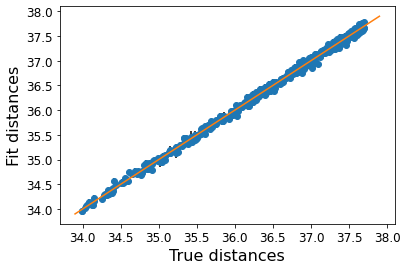

In [ ]:
f = plt.figure()
plt.plot(true_mus, fit_mus, 'o')
plt.errorbar(true_mus, fit_mus, np.sqrt(np.array(mu_variances)), color = 'k', linestyle = 'None')
plt.plot(np.linspace(33.9, 37.9),np.linspace(33.9, 37.9))
plt.xlabel("True distances", fontsize = 16)
plt.ylabel("Fit distances", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
f.savefig("True_v_fit_distances.pdf", bbox_inches = 'tight')

(array([-0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ]),
 <a list of 9 Text major ticklabel objects>)

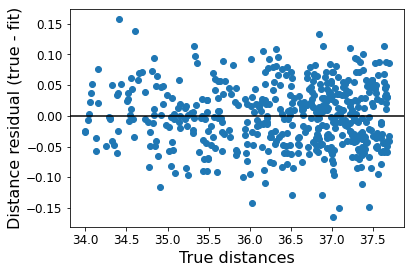

In [ ]:
residuals = fit_mus - true_mus
plt.plot(true_mus, residuals, 'o')
plt.axhline(0, color = 'k')
plt.xlabel("True distances", fontsize = 16)
plt.ylabel("Distance residual (true - fit)", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

In [ ]:
count = 0
for i in range(len(true_mus)):
  if residuals[i] <= np.sqrt(mu_variances[i]):
    count += 1

In [ ]:
count / len(true_mus)

0.82

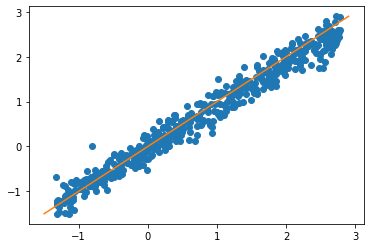

In [ ]:
plt.plot(true_thetas, fit_thetas, 'o')
plt.plot(np.linspace(-1.5, 2.9),np.linspace(-1.5, 2.9))

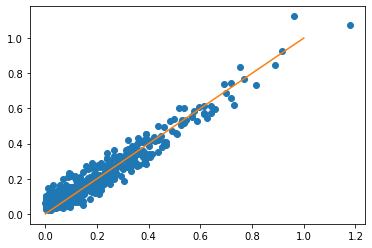

In [ ]:
plt.plot(true_avs, fit_avs, 'o')
plt.plot(np.linspace(0, 1),np.linspace(0, 1))

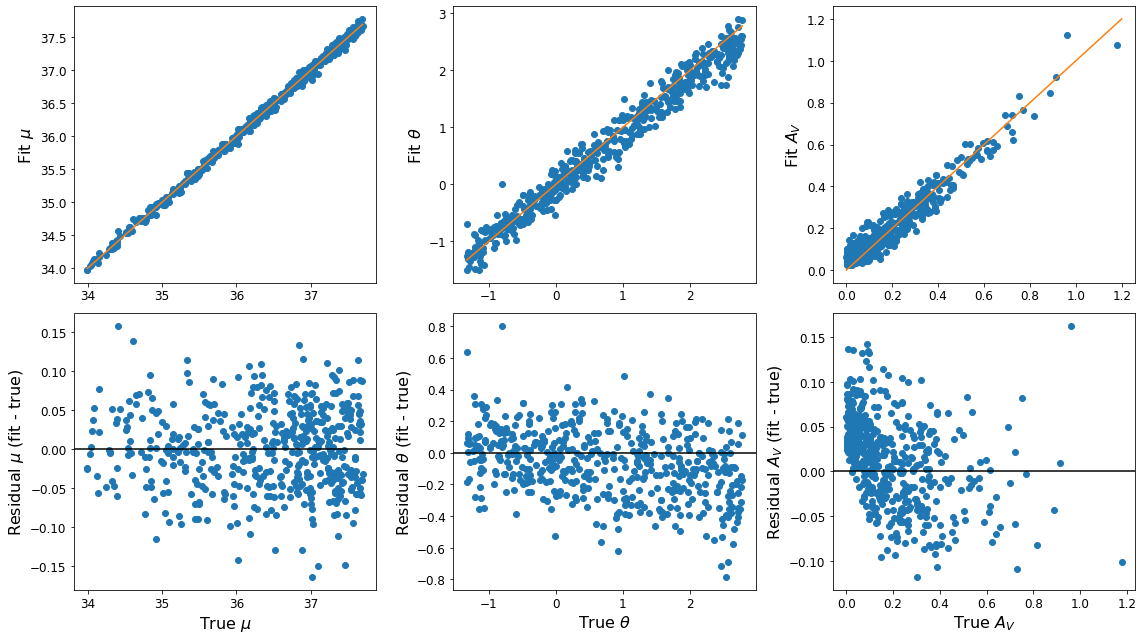

In [ ]:
fig, ax = plt.subplots(2,3, figsize = (16,9))
ax[0][0].plot(true_mus, fit_mus, 'o')
ax[0][0].plot(np.linspace(min(true_mus), max(true_mus)),np.linspace(min(true_mus), max(true_mus)))
ax[0][0].set_ylabel('Fit $\\mu$', fontsize = 16)
# ax[0][0].set_xlabel('True $\\mu$', fontsize = 16)


ax[1][0].plot(true_mus, fit_mus - true_mus, 'o')
ax[1][0].axhline(0, color = 'k')
ax[1][0].set_ylabel('Residual $\\mu$ (fit - true)', fontsize = 16)
ax[1][0].set_xlabel('True $\\mu$', fontsize = 16)


ax[0][1].plot(true_thetas, fit_thetas, 'o')
ax[0][1].plot(np.linspace(min(true_thetas), max(true_thetas)),np.linspace(min(true_thetas), max(true_thetas)))
ax[0][1].set_ylabel('Fit $\\theta$', fontsize = 16)
# ax[0][1].set_xlabel('True $\\theta$', fontsize = 16)

ax[1][1].plot(true_thetas, fit_thetas - true_thetas, 'o')
ax[1][1].axhline(0, color = 'k')
ax[1][1].set_ylabel('Residual $\\theta$ (fit - true)', fontsize = 16)
ax[1][1].set_xlabel('True $\\theta$', fontsize = 16)

ax[0][2].plot(true_avs, fit_avs, 'o')
ax[0][2].plot(np.linspace(0, 1.2),np.linspace(0, 1.2))
ax[0][2].set_ylabel('Fit $A_V$', fontsize = 16)
# ax[0][2].set_xlabel('True $A_V$', fontsize = 16)

ax[1][2].plot(true_avs, fit_avs - true_avs, 'o')
ax[1][2].axhline(0, color = 'k')
ax[1][2].set_ylabel('Residual $A_V$ (fit - true)', fontsize = 16)
ax[1][2].set_xlabel('True $A_V$', fontsize = 16)

for axis in ax.flatten():
  axis.tick_params(axis='x', labelsize=12)
  axis.tick_params(axis='y', labelsize=12)

plt.tight_layout()

fig.savefig("SimulationComparison.pdf", bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/corner/core.py:635: MatplotlibDeprecationWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, "o", zorder=-1, rasterized=True, **data_kwargs)
/usr/local/lib/python3.7/dist-packages/corner/core.py:635: MatplotlibDeprecationWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, "o", zorder=-1, rasterized=True, **data_kwargs)
/usr/local/lib/python3.7/dist-packages/corner/core.py:635: MatplotlibDeprecationWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, "o", zorder=-1, rasterized=True, **data_kwa

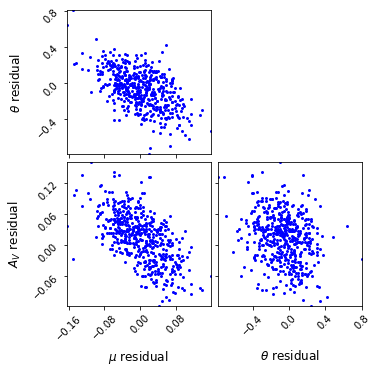

In [ ]:
fig = corner.corner(np.vstack((residuals, fit_thetas - true_thetas, fit_avs - true_avs)).T, plot_contours = False, plot_datapoints =  True, plot_density = False, 
              data_kwargs = {'color':'b', 'alpha':1, 'marker':'o', 'markersize':3}, labels = ['$\\mu$ residual', '$\\theta$ residual', '$A_V$ residual'],
              label_kwargs = {'fontsize':12})
axes = np.array(fig.axes).reshape((3, 3))
for a in axes[np.triu_indices(3)]:
  a.remove()

fig.savefig("Residuals_corner_plot.pdf", bbox_inches = 'tight')

In [ ]:
linspace_z = np.linspace(0.01, 0.085)

cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)
cosmo_distmod_values = np.array([cosmo.distmod(z).value for z in linspace_z])

In [ ]:
def plot_hubble_distances_and_residuals(mus, vars, z_cmbs, linspace_z = linspace_z, cosmo_distmod_values = cosmo_distmod_values):
  predictions = mus
  targets = np.array([cosmo.distmod(z).value for z in z_cmbs])
  rmse = np.sqrt(np.mean((predictions-targets)**2))
  
  fig, ax = plt.subplots(2,1, figsize = (6,9))
  ax[0].plot(z_cmbs, mus,'o')
  ax[0].plot(linspace_z, cosmo_distmod_values, color = 'k')
  ax[0].errorbar(z_cmbs, mus, np.sqrt(vars), linestyle = 'None', color = 'k')
  ax[0].set_xlabel("Recession velocity (speed of light)", fontsize =14)
  ax[0].set_ylabel("log(distance)", fontsize = 14)
  plt.text(0.07, 1.0, "Foundation DR1", fontsize = 16, horizontalalignment = 'center')
  plt.text(0.07, 0.9, "N = " + str(len(z_cmbs)), fontsize = 16, horizontalalignment = 'center')
  plt.text(0.07, 0.8, "RMSE = " + str(round(rmse,2)), fontsize = 16, horizontalalignment = 'center')


  sigma_pec = 150
  c = 300000
  ax[1].plot(z_cmbs, mus - np.array(targets), 'o')
  print(np.mean(mus - np.array(targets)), "+/-", np.std(mus - np.array(targets)) / np.sqrt(len(z_cmbs)))

  ax[1].errorbar(z_cmbs, mus - np.array(targets), np.sqrt(vars), linestyle = 'None', color = 'k')

  sigma_envelope = np.array([(5 / (z * np.log(10))) * (sigma_pec / c) for z in linspace_z])
  ax[1].plot(linspace_z, sigma_envelope, marker = 'None', linestyle = 'dashed', color = 'k')
  ax[1].plot(linspace_z, -sigma_envelope, marker = 'None', linestyle = 'dashed', color = 'k')

  ax[1].axhline(0., color = 'k')
  ax[1].set_xlabel("z", fontsize = 14)
  ax[1].set_ylabel("Hubble Residual", fontsize = 14)

  return fig

-0.0001657280550811322 +/- 0.002302661518301876


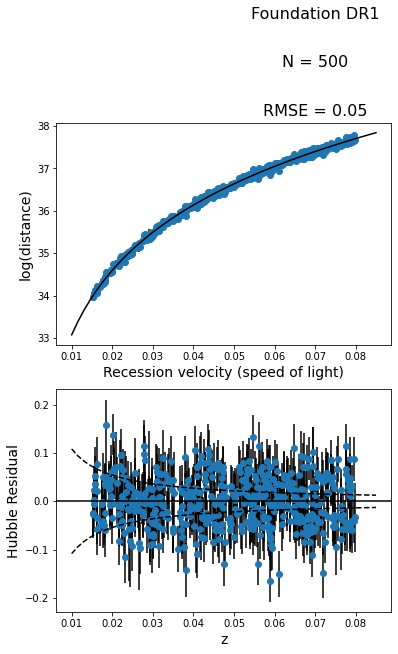

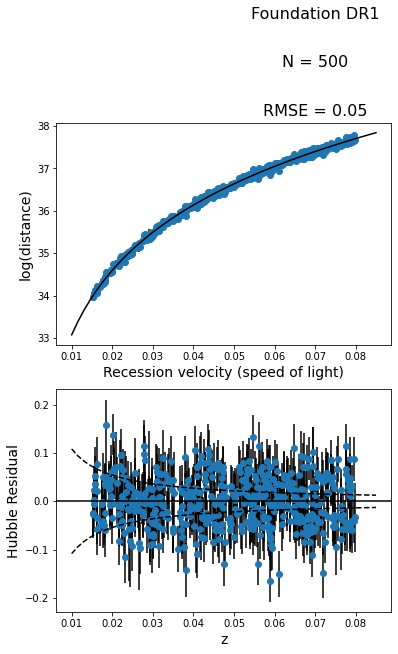

In [ ]:
plot_hubble_distances_and_residuals(fit_mus, mu_variances, true_zs)

## Generate sample population for training

In [ ]:
def make_times_into_dictionary(times):
  ret_dict = {}
  for band in ['g', 'r', 'i', 'z']:
    ret_dict[band] = times
  return ret_dict

In [ ]:
true_distances = []
true_thetas = []
true_avs = []
true_nus = []
true_zs = []
true_rvs = []

# vi_laplace_locs = []
# vi_laplace_scale_trils = []

simulated_times = []
simulated_fluxes= []

true_rv_mean = 2.7
true_rv_std = 0.5
true_tau = 0.4

while len(simulated_times) < 100:

  try:
    z = pyro.sample("z", dist.Uniform(0.015, 0.08)).numpy()
    
    true_mu_s = cosmo.distmod(z).value

    this_rv = pyro.sample("rv", dist.Normal(true_rv_mean, true_rv_std)).numpy()

    true_theta = pyro.sample("theta", dist.Uniform(-1.33,2.78)).numpy() # for T21

    true_Av = pyro.sample("Av", dist.Exponential(1 / true_tau)).numpy()

    true_nu = pyro.sample("nu", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = torch.eye(len(eps_cov)))).numpy()

    true_epsilon_interior = np.matmul(L_sigma_epsilon, true_nu.T)

    tmax = pyro.sample("tmax", dist.Uniform(57100,57800)).numpy()
    tfirst = pyro.sample("tfirst", dist.Uniform(float(tmax) - 10, float(tmax) - 5)).numpy()
    times_MJD = np.array([tfirst + 6*i for i in range(6)])
    times = (times_MJD - tmax) / (1 + z)

    observed_z = pyro.sample("observed_z", dist.Normal(torch.as_tensor(z), 1.e-4))
    mu_mean = torch.as_tensor(cosmo.distmod(observed_z.numpy()).value)

    Jt, band_Jl, band_xis_matrix, band_S0, band_h, all_band_fluxes = get_band_specific_stuff(times, z, true_epsilon_interior, true_theta, true_mu_s, true_Av, dMs = 0, rv = this_rv)

    # print(times.shape, all_band_fluxes.shape)

    simulated_times.append(times)
    simulated_fluxes.append(all_band_fluxes)
    true_zs.append(z)
    true_distances.append(true_mu_s)
    true_thetas.append(true_theta)
    true_avs.append(true_Av)
    true_nus.append(true_nu)
    true_rvs.append(this_rv)

  except:
    print("didn't work")


In [ ]:
np.savez("simulation_true_values_training_080322", true_zs=np.array(true_zs), true_distances=np.array(true_distances), true_thetas=np.array(true_thetas), true_avs=np.array(true_avs), true_nus=np.array(true_nus), true_rvs=np.array(true_rvs), simulated_times=simulated_times, simulated_fluxes=simulated_fluxes)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  val = np.asanyarray(val)
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


## Generating giant corner plot that I don't really need anymore

In [ ]:
mcmc_eps_row_samples = []
mcmc_eps_column_samples = []

vi_eps_row_samples = []
vi_eps_column_samples = []

for i in range(num_corner_samples):
  mcmc_eps_int = np.matmul(L_sigma_epsilon, mcmc_corner_samples['nu'].numpy()[i]).reshape((9,6), order = 'F')
  mcmc_eps_row_samples.append(mcmc_eps_int[1])
  mcmc_eps_column_samples.append(mcmc_eps_int[:,1])

  vi_eps_int = np.matmul(L_sigma_epsilon, vi_corner_samples['nu'][:,0,0].numpy()[i]).reshape((9,6), order = 'F')
  vi_eps_row_samples.append(vi_eps_int[1])
  vi_eps_column_samples.append(vi_eps_int[:,1])


mcmc_eps_row_samples = np.array(mcmc_eps_row_samples)
mcmc_eps_column_samples = np.array(mcmc_eps_column_samples)
vi_eps_row_samples = np.array(vi_eps_row_samples)
vi_eps_column_samples = np.array(vi_eps_column_samples)

mcmc_eps_row_samples.shape, vi_eps_column_samples.shape

In [ ]:
true_epsilon_row = true_epsilon_interior.reshape((9,6), order = 'F')[1]
true_epsilon_column = true_epsilon_interior.reshape((9,6), order = 'F')[:,1]

In [ ]:
figure = corner.corner(np.vstack((vi_corner_samples['mu_s'][:,0,0].numpy(),vi_corner_samples['theta'][:,0,0].numpy(), 
                                  vi_corner_samples['Av'][:,0,0].numpy(), vi_eps_row_samples.T)).T, 
                       labels = [r"VI $\mu_s$", r"VI $\theta$", r"VI $A_v$"] + ["epsilon[1]["+str(i)+"]" for i in range(9)])
corner.corner(np.vstack((mcmc_corner_samples['mu_s'],mcmc_corner_samples['theta'],mcmc_corner_samples['Av'], mcmc_eps_row_samples.T)).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"] + ["epsilon[1]["+str(i)+"]" for i in range(9)], fig = figure, color ='r')
# corner.corner(np.vstack((mcmc_corner_samples['mu_s'][7500:10000],mcmc_corner_samples['theta'][7500:10000],mcmc_corner_samples['Av'][7500:10000])).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color  = 'r')
# corner.corner(np.vstack((mcmc_corner_samples['mu_s'][2500:5000],mcmc_corner_samples['theta'][2500:5000],mcmc_corner_samples['Av'][2500:5000])).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color  = 'b')
corner.overplot_lines(figure, [true_mu_s, true_theta, true_Av] + list(true_epsilon_row), color = 'g')
colors = ['k', 'r', 'g']
labels = ['Variational Inference', 'MCMC', 'True Values']
plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=labels[i])
        for i in range(len(labels))
    ],
    fontsize=20, frameon=False,
    bbox_to_anchor=(1, 3), loc="upper right"
)
figure.savefig("eps_row_corner_plot.pdf", bbox_inches = 'tight')

In [ ]:
figure = corner.corner(np.vstack((vi_corner_samples['mu_s'][:,0,0].numpy(),vi_corner_samples['theta'][:,0,0].numpy(), 
                                  vi_corner_samples['Av'][:,0,0].numpy(), vi_eps_column_samples.T)).T, 
                       labels = [r"VI $\mu_s$", r"VI $\theta$", r"VI $A_v$"] + ["epsilon[1]["+str(i)+"]" for i in range(9)])
corner.corner(np.vstack((mcmc_corner_samples['mu_s'],mcmc_corner_samples['theta'],mcmc_corner_samples['Av'], mcmc_eps_column_samples.T)).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"] + ["epsilon["+str(i)+"][1]" for i in range(9)], fig = figure, color ='r')

corner.corner(np.vstack((laplace_corner_samples['mu_s'][:,0,0].numpy(),laplace_corner_samples['theta'][:,0,0].numpy(), 
                                 laplace_corner_samples['Av'][:,0,0].numpy())).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color ='tab:purple')
corner.corner(np.vstack((vi_corner_samples['mu_s'][:,0,0].numpy(),vi_corner_samples['theta'][:,0,0].numpy(), 
                                  vi_corner_samples['Av'][:,0,0].numpy(), vi_eps_column_samples.T)).T, 
                       labels = [r"VI $\mu_s$", r"VI $\theta$", r"VI $A_v$"] + ["epsilon[1]["+str(i)+"]" for i in range(9)])
# corner.corner(np.vstack((mcmc_corner_samples['mu_s'][7500:10000],mcmc_corner_samples['theta'][7500:10000],mcmc_corner_samples['Av'][7500:10000])).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color  = 'r')
# corner.corner(np.vstack((mcmc_corner_samples['mu_s'][2500:5000],mcmc_corner_samples['theta'][2500:5000],mcmc_corner_samples['Av'][2500:5000])).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color  = 'b')
corner.overplot_lines(figure, [true_mu_s, true_theta, true_Av] + list(true_epsilon_column), color = 'g')
colors = ['k', 'r', 'g']
labels = ['Variational Inference', 'MCMC', 'True Values']
plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=labels[i])
        for i in range(len(labels))
    ],
    fontsize=20, frameon=False,
    bbox_to_anchor=(1, 3), loc="upper right"
)
figure.savefig("eps_column_corner_plot.pdf", bbox_inches = 'tight')